In [ ]:
#installing required libraries
!pip install yfinance
!pip install pyts
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import tensorflow as tf
import tensorflow_datasets as tfds
from pyts.image import GramianAngularField
from skimage.transform import resize


In [ ]:
import math

import six
from einops.layers.tensorflow import Rearrange
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import datasets

import logging
import numpy as np

from fastprogress import master_bar, progress_bar

In [ ]:
# Code to download the stock data
stock_symbol = 'KOTAKBANK.NS'

# Fetch historical data for the company
stock_data = yf.download(stock_symbol, period="5y")
df = pd.DataFrame(stock_data)
df.reset_index(inplace = True)

print("Size of the data: ",df.shape[0])

[*********************100%%**********************]  1 of 1 completed
Size of the data:  1236


In [ ]:
#Compute the mid value for the stock, that would be considered as that day's price
df['Mid'] = (df['Low']+df['High'])/2.0

In [ ]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,2018-12-11,1189.000000,1239.000000,1171.000000,1218.699951,1215.705444,10078591,1205.000000
1,2018-12-12,1229.400024,1261.000000,1224.199951,1237.150024,1234.110229,6563999,1242.599976
2,2018-12-13,1240.000000,1271.800049,1228.599976,1264.400024,1261.292969,4227732,1250.200012
3,2018-12-14,1264.400024,1271.699951,1247.099976,1255.949951,1252.863770,2671529,1259.399963
4,2018-12-17,1260.000000,1266.000000,1207.050049,1222.449951,1219.446045,7385641,1236.525024


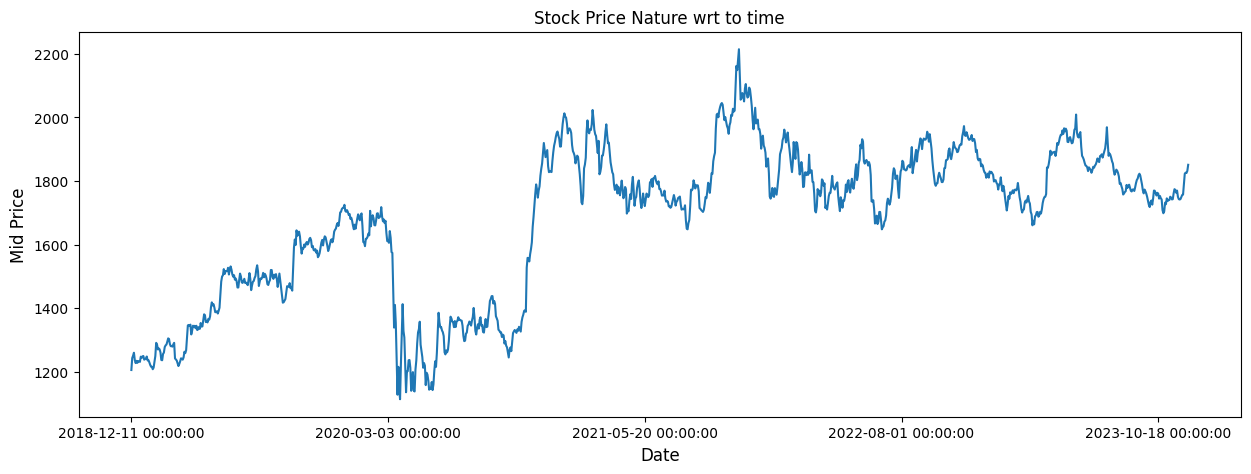

In [ ]:
#Visualize the nature of price through out the time period
plt.figure(figsize = (15,5))
plt.plot(range(df.shape[0]),(df['Mid']))
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=0)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.title("Stock Price Nature wrt to time")
plt.show()

In [ ]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Mid"

In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [ ]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [ ]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
0,2018-12-11,1189.000000,1239.000000,1171.000000,1218.699951,1215.705444,10078591,1205.000000,1242.599976,1
1,2018-12-12,1229.400024,1261.000000,1224.199951,1237.150024,1234.110229,6563999,1242.599976,1250.200012,1
2,2018-12-13,1240.000000,1271.800049,1228.599976,1264.400024,1261.292969,4227732,1250.200012,1259.399963,1
3,2018-12-14,1264.400024,1271.699951,1247.099976,1255.949951,1252.863770,2671529,1259.399963,1236.525024,0
4,2018-12-17,1260.000000,1266.000000,1207.050049,1222.449951,1219.446045,7385641,1236.525024,1226.825012,0


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
1231,2023-12-05,1828.000000,1837.000000,1808.500000,1828.449951,1828.449951,5571472,1822.750000,1826.250000,1
1232,2023-12-06,1832.050049,1839.349976,1813.150024,1821.400024,1821.400024,4695880,1826.250000,1825.125000,0
1233,2023-12-07,1825.000000,1836.849976,1813.400024,1826.849976,1826.849976,2500642,1825.125000,1831.849976,1
1234,2023-12-08,1826.849976,1843.000000,1820.699951,1838.449951,1838.449951,2985466,1831.849976,1850.975037,1
1235,2023-12-11,1845.000000,1861.650024,1840.300049,1844.050049,1844.050049,3204785,1850.975037,NaN,0


In [ ]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times


test_df = df[(df.index >= last_10pct)]

train_df = df[(df.index < last_10pct)]  # now the train_df is all the data up to the last 10%

In [ ]:
from collections import deque
import numpy as np
import random

In [ ]:
train_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
#validation_df.drop(columns=["Date", 'future','Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
test_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)# don't need this anymore.

<ipython-input-16-1c2e98b01d64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
<ipython-input-16-1c2e98b01d64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)# don't need this anymore.


In [ ]:
train_df.head()

,Mid,target
0,1205.000000,1
1,1242.599976,1
2,1250.200012,1
3,1259.399963,0
4,1236.525024,0


In [ ]:
train_data = train_df[RATIO_TO_PREDICT].values
train_label = train_df['target'].values

test_data = test_df[RATIO_TO_PREDICT].values
test_label = test_df['target'].values

In [ ]:
train_data = train_data.reshape(-1,1)
train_label = train_label.reshape(-1,1)

test_data = test_data.reshape(-1,1)
test_label = test_label.reshape(-1,1)

In [ ]:
train_data.shape

(1113, 1)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 3000
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size, :])
    train_data[di:di+smoothing_window_size, :] = scaler.transform(train_data[di:di+smoothing_window_size, :])

# Handling the remaining data after the loop
remaining_data = len(train_data) - (di + smoothing_window_size)
if remaining_data > 0:
    scaler.fit(train_data[di+smoothing_window_size:, :])
    train_data[di+smoothing_window_size:, :] = scaler.transform(train_data[di+smoothing_window_size:, :])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
train_label = train_label.reshape(-1)
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
test_label = test_label.reshape(-1)

In [ ]:
train_data.shape

(1113,)

In [ ]:
train_data

array([0.08345814, 0.11758564, 0.12448379, ..., 0.72173815, 0.69539362,
       0.6908781 ])

In [ ]:
train_label.shape

(1113,)

In [ ]:
train_label

array([1, 1, 1, ..., 0, 0, 0])

RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


train_data = np.reshape(train_data, (train_data.shape[0], 1, 1))

model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(1, 1), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_label, epochs=80, batch_size=32)


Epoch 1/80
35/35 [==============================] - 5s 4ms/step - loss: 0.6930 - accuracy: 0.5085
Epoch 2/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5292
Epoch 3/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5292
Epoch 4/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5292
Epoch 5/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5292
Epoch 6/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5292
Epoch 7/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5292
Epoch 8/80
35/35 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5292
Epoch 9/80
35/35 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5292
Epoch 10/80
35/35 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5292
Epoch 11/80
35/35 [

In [ ]:
# Reshape the test data similarly to the training data
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_label)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

4/4 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4797
Test Loss: 0.6958
Test Accuracy: 47.97%


LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Building the LSTM model with relu activation function and the output layer with sigmoid activation function
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, 1), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_label, epochs=80, batch_size=32)


Epoch 1/80
35/35 [==============================] - 3s 10ms/step - loss: 0.6931 - accuracy: 0.5103
Epoch 2/80
35/35 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5292
Epoch 3/80
35/35 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.5292
Epoch 4/80
35/35 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.5292
Epoch 5/80
35/35 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.5292
Epoch 6/80
35/35 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5292
Epoch 7/80
35/35 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5292
Epoch 8/80
35/35 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5292
Epoch 9/80
35/35 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5292
Epoch 10/80
35/35 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5292
Epoch 11/80
35/

In [ ]:
test_data = np.reshape(test_data, (test_data.shape[0], 1, 1))

# Evaluating the model on the test data
loss, accuracy = model.evaluate(test_data, test_label)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')


4/4 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4715
Test Loss: 0.6955
Test Accuracy: 47.15%
